### Import

In [21]:
import numpy as np
from scipy.constants import *
import matplotlib.pyplot as plt
from tqdm import tqdm

In [22]:
def pointCharge(q, r_s, r_m):
    ### Calculates the EM field of an assembly of point charges ###
    
    #Each pc in pc_ass has 4 dimensions
    #pc[0] == charge
    #pc[1:end] == source position
    #r_m == measurement position from the origin
    k=9e9 #Initialize
    #Define the distance from the source to our measurement
    r = r_m - r_s
    rSqrd = r[:,0]**2 + r[:,1]**2 + r[:,2]**2
    
    #Ignore the points that cause an infinite electromagnetic field
    inf_ind = np.where(rSqrd==0)
    q = np.delete(q,inf_ind)
    rSqrd = np.delete(rSqrd,inf_ind)
    
    r = np.delete(r,inf_ind, axis=0)
    
    #Reshape rSqrd and q for vectorised calculations
    rSqrd = np.reshape(rSqrd,(len(rSqrd),1))
    q = np.reshape(q,(len(q),1))
    
    #Define the unit vector of the EM field
    rHat = r/rSqrd**0.5
    
    #Use Coulomb's Law to analytically calculate the EM field
    E_array = k*q/rSqrd * rHat
    
    return  np.array([np.sum(E_array[:,0]), np.sum(E_array[:,1]), np.sum(E_array[:,2])]) #Add the contribution from each point charge

In [23]:
def lineCharge(L, q_tot, r_s0, v_s0, r_m, N):
    ### Calculates the EM field of a finite line charge ###
    
    #L == length
    #q_tot == total charge carried by the wire
    #r_s0 == point at one end of the line charge
    #v_s0 == unit vector oriented along the line charge (relative to the origin)
    #r_m == radius of measurement (relative to the origin)
    #N == number of sample points
    
    #Ensure that v_s0 is a unit vector
    v_s0 = v_s0/np.dot(v_s0,v_s0)**0.5
    
    dq = np.ones(N) * (q_tot/N)
    range_ = np.linspace(0,L,N)
    r_s = r_s0 + np.array([v_s0[0]*range_, v_s0[1]*range_, v_s0[2]*range_]).T
    
    return pointCharge(dq, r_s, r_m), r_s

In [24]:
def plateCharge(L, q_tot, z, r_m, N):
    ## Measures the electric field produced by a plate orinted in the x-y plane ##
    #L == length of the square plate
    #q_tot == total charge carried by the plate
    #z is the position of the plate
    #r_m == radius of measurement (relative to the origin)
    #N == number of sample points
    
    #Define the differential charge
    dq = q_tot/N**2
    
    #Define the array of source points
    rn = np.linspace(0,L,N)
    x,y=np.meshgrid(rn,rn)
    X = np.reshape(x,(N,N,1))
    Y = np.reshape(y,(N,N,1))
    
    r_sAr = np.append(X,Y,axis=2)
    r_s = np.reshape(r_sAr,(N**2,2)) #Flatten
    
    Z = np.ones((N**2,1)) * z #Make it 3D
    r_s = np.append(r_s,Z,axis=1)
    
    return pointCharge(dq, r_s, r_m)

In [25]:
def capacitor(L, d, V, C, r_m, N):
    #Total charge on the place of a capacitor
    Q = C*V
    #Sum the contributions of each plate
    E = plateCharge(L=L, q_tot=Q, z=d, r_m=r_m, N=N) + plateCharge(L=L, q_tot=-Q, z=0, r_m=r_m, N=N)
    return E

The electric field is: E = 488.0 i + 367.0 j + 0.0 k at the point of measurement


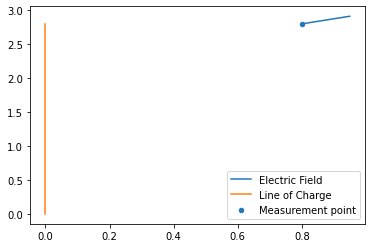

In [26]:
#Parameters
L=2.8
q_tot=126e-9
r_s0=np.array([0,0,0])
v_s0=np.array([0,1,0])
r_m = np.array([0.8,L,0])
N=500

#Calculate
E, r_s = lineCharge(L, q_tot, r_s0, v_s0, r_m, N)
print('The electric field is: E = {} i + {} j + {} k at the point of measurement'.format(round(E[0],0), round(E[1],0), round(E[2],0)))

#Create vector field
E = E/np.dot(E,E)**0.5 #Scale
rn = np.array([0,L/15])
Efield = r_m + np.array([E[0]*rn, E[1]*rn, E[2]*rn]).T

plt.plot(Efield[:,0], Efield[:,1])
plt.plot(r_s[:,0],r_s[:,1])
plt.scatter(r_m[0],r_m[1], s=20)
plt.legend(['Electric Field',
            'Line of Charge',
            'Measurement point'],
          loc = 'best')
plt.show()

The electric field is: E = 0.76 i + 0.0 j + -0.3 k at the point of measurement


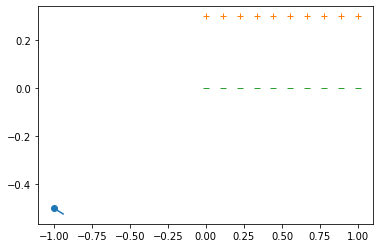

In [103]:
L = 1
d = 0.3
V = 1
C = 1e-9
r_m = np.array([-1, L/2, -0.5])
N = 100

E = capacitor(L, d, V, C, r_m, N)
print('The electric field is: E = {} i + {} j + {} k at the point of measurement'.format(round(E[0],2), round(E[1],2), round(E[2],2)))
E = E/np.dot(E,E)**0.5
rn = np.array([0,L/15])
Efield = r_m + np.array([E[0]*rn, E[1]*rn, E[2]*rn]).T
plt.plot(Efield[:,0], Efield[:,2])
plt.scatter(r_m[0],r_m[2])
plt.plot(np.linspace(0,L,10),np.ones(10)*d,'+')
plt.plot(np.linspace(0,L,10),np.zeros(10),'_')
plt.show()

In [74]:
def capField(L, d, V, C, N, n_m):
    
    #Plot the capacitor
    plt.plot(np.linspace(0,L,10),np.ones(10)*d,'+')
    plt.plot(np.linspace(0,L,10),np.zeros(10),'_')
    
    #Define the points to measure the field
    ran = np.linspace(-L/2,3*L/2,n_m)
    range_ = np.array([0,L/10])
    
    #Measure the field at multiple points
    for i in tqdm(range(n_m)):
        for k in range(n_m):
        #Define the measurement point
            r_m = np.array([ran[i], L/2, ran[k]])

            #Measure the electric field at that point
            E_i = capacitor(L, d, V, C, r_m, N)
            magE_i = np.dot(E_i,E_i)**0.5 #Save for colour of vector
            E_i = E_i/magE_i #Normalize for ease of display

            #Create the electric field vectors
            rn = np.array([0,L/15])
            Efield = r_m + np.array([E[0]*range_, E[1]*range_, E[2]*range_]).T
            plt.plot(Efield[:,0], Efield[:,2], 'b', linewidth=magE_i/20)
            plt.scatter(r_m[0],r_m[2], c='b', s=1)
    
    plt.xlabel('x')
    plt.ylabel('z')
    plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 45.78it/s]


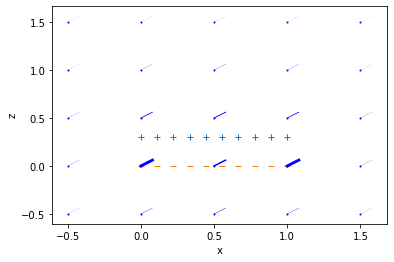

In [75]:
capField(L=1, d=0.3, V=1, C=1e-9, N=50, n_m=5)